In [28]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import os
import zipfile
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

In [30]:
def delete_directory(path):
    """
    Deletes the directory at the specified path, including all subfolders and files.

    Parameters:
    path (str): The path of the directory to delete.
    """
    if os.path.exists(path) and os.path.isdir(path):
        shutil.rmtree(path)
        print(f"Deleted directory: {path}")
    else:
        print(f"Directory does not exist: {path}")

In [34]:
# https://storage.googleapis.com/learning-datasets/horse-or-human.zip
# https://storage.googleapis.com/learning-datasets/validation-horse-or-human.zip

train_file_name= "horse-or-human.zip"
validation_file_name = "validation-horse-or-human.zip"
files_to_read= [train_file_name, validation_file_name]

# function to copy the dataset to a destination directory
def copy_dataset(source, destination, files_to_read):
    if not os.path.exists(destination):
        os.makedirs(destination)
    for item in files_to_read:
        source_path = os.path.join(source, item)
        destination_path = os.path.join(destination, item)
        if os.path.isdir(source_path): # Check if it's a directory
            # If it's a directory, copy the entire directory
            copy_dataset(source_path, destination_path)
            print(f"Copied directory: {source_path} to {destination_path}")
        else: # If it's a file, copy the file
            tf.io.gfile.copy(source_path, destination_path)
            print(f"Copied file: {source_path} to {destination_path}")

In [35]:
source= "C:/Users/xperi/Downloads"
destination= "C:/Users/xperi/Downloads/datasets"
delete_directory(destination)  # Clean up the destination directory before copying
copy_dataset(source, destination, files_to_read)

Deleted directory: C:/Users/xperi/Downloads/datasets
Copied file: C:/Users/xperi/Downloads\horse-or-human.zip to C:/Users/xperi/Downloads/datasets\horse-or-human.zip
Copied file: C:/Users/xperi/Downloads\validation-horse-or-human.zip to C:/Users/xperi/Downloads/datasets\validation-horse-or-human.zip


In [36]:
# extract training dataset
local_zip = os.path.join(destination, train_file_name)
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(destination + '/horse-or-human')

#extract validation dataset
local_zip = os.path.join(destination, validation_file_name)
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall(destination + '/validation-horse-or-human')
zip_ref.close()

# Define directories for training and validation datasets
train_dir = os.path.join(destination, 'horse-or-human')
validation_dir = os.path.join(destination, 'validation-horse-or-human')
train_horses_dir = os.path.join(destination, 'horse-or-human', 'horses')
# get all file names in the directory
train_horse_names= os.listdir(train_horses_dir)

train_humans_dir = os.path.join(destination, 'horse-or-human', 'humans')
# get all file names in the directory
train_human_names = os.listdir(train_humans_dir)

validation_horses_dir = os.path.join(destination, 'validation-horse-or-human', 'horses')
validation_humans_dir = os.path.join(destination, 'validation-horse-or-human', 'humans')

In [37]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 3)), # 32 filters so 32 biases, 3*3*3 (width, height, color channels)
    # so num of parameters are 32 * (3*3*3 + 1) = 896
    #output shape is (None, 98, 98, 32)
    tf.keras.layers.MaxPooling2D(2, 2), # output shape is 49, 49, 32
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    # so num of parameters are 64 * (3*3*32 + 1) = 18496
    #output shape is (None, 47, 47, 64)
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class 
    # ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

c:\Users\xperi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,617,665 (9.99 MB)

 Trainable params: 2,617,665 (9.99 MB)

 Non-trainable params: 0 (0.00 B)

None


In [39]:
optimizer = RMSprop(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [45]:
train_datagen = ImageDataGenerator(
      rescale=1./255,
      # rotation_range=40,
      # width_shift_range=0.2,
      # height_shift_range=0.2,
      # shear_range=0.2,
      # zoom_range=0.2,
      # horizontal_flip=True,
      # fill_mode='nearest'
      )

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,  # This is the source directory for training images
        target_size=(100, 100),  # All images will be resized to 100x100
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

Found 1027 images belonging to 2 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(100, 100), # this means that all images will be resized to 100x100
        class_mode='binary')

Found 256 images belonging to 2 classes.


In [47]:
history = model.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=100,
      verbose=1,
      validation_data=validation_generator)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 462ms/step - acc: 0.9898 - loss: 0.0803 - val_acc: 0.6484 - val_loss: 1.5637
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - acc: 1.0000 - loss: 0.0886 - val_acc: 0.7656 - val_loss: 0.8755
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 455ms/step - acc: 0.9369 - loss: 0.1404 - val_acc: 0.7109 - val_loss: 1.2598
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - acc: 0.9922 - loss: 0.0495 - val_acc: 0.7109 - val_loss: 1.2649
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - acc: 0.9941 - loss: 0.0429 - val_acc: 0.7031 - val_loss: 1.4910
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - acc: 0.6667 - loss: 0.3049 - val_acc: 0.9375 - val_loss: 0.1509
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - acc: 0.8556 - loss: 0.5549 - val_acc: 0.7148 - val_loss: 1.3806
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step - acc: 0.9844 - loss: 0.0445 - val_acc: 0.7109 - val_loss: 1.4322
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - acc: 0.9921 - loss:

In [48]:
import numpy as np
from tensorflow.keras import utils

#ask user to upload a file

img_folder_path = r"C:/Users/xperi/Downloads/testing/" 

for img_file in os.listdir(img_folder_path):
    img_path = os.path.join(img_folder_path, img_file)
    if not os.path.isfile(img_path):
        continue  # Skip if it's not a file or if it's a directory
    print(f"Processing image: {img_path}")
    # Load and preprocess image
    img = utils.load_img(img_path, target_size=(100, 100))
    x = utils.img_to_array(img)
    x = x / 255.0
    x = np.expand_dims(x, axis=0)
    # Predict
    classes = model.predict(x)
    print(classes)
    if classes[0] > 0.5:
        print(f"{os.path.basename(img_path)} is a human")
    else:
        print(f"{os.path.basename(img_path)} is a horse")
 

Processing image: C:/Users/xperi/Downloads/testing/horse5-103.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
[[0.99844664]]
horse5-103.png is a human
Processing image: C:/Users/xperi/Downloads/testing/horse5-123.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
[[1.]]
horse5-123.png is a human
Processing image: C:/Users/xperi/Downloads/testing/horse5-164.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
[[0.9999886]]
horse5-164.png is a human
Processing image: C:/Users/xperi/Downloads/testing/horse5-181.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
[[0.2931001]]
horse5-181.png is a horse
Processing image: C:/Users/xperi/Downloads/testing/horse5-192.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
[[0.01127183]]
horse5-192.png is a horse
Processing image: C:/Users/xperi/Downloads/testing/valhuman01-10.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
[[1.]]
valhuman01-10.png is a human
Processing image: C:/Users/xperi/Downloads/testing/valhuman01-11.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
[[1.]]
valhuman01-11.png is a 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step


C:\Users\xperi\AppData\Local\Temp\ipykernel_7824\154013054.py:50: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
C:\Users\xperi\AppData\Local\Temp\ipykernel_7824\154013054.py:53: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


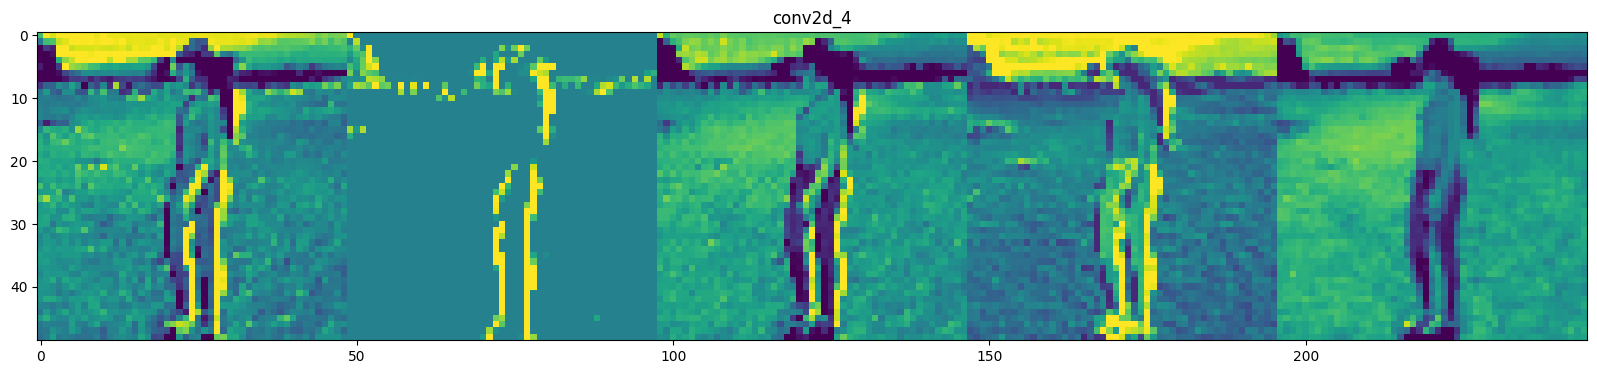

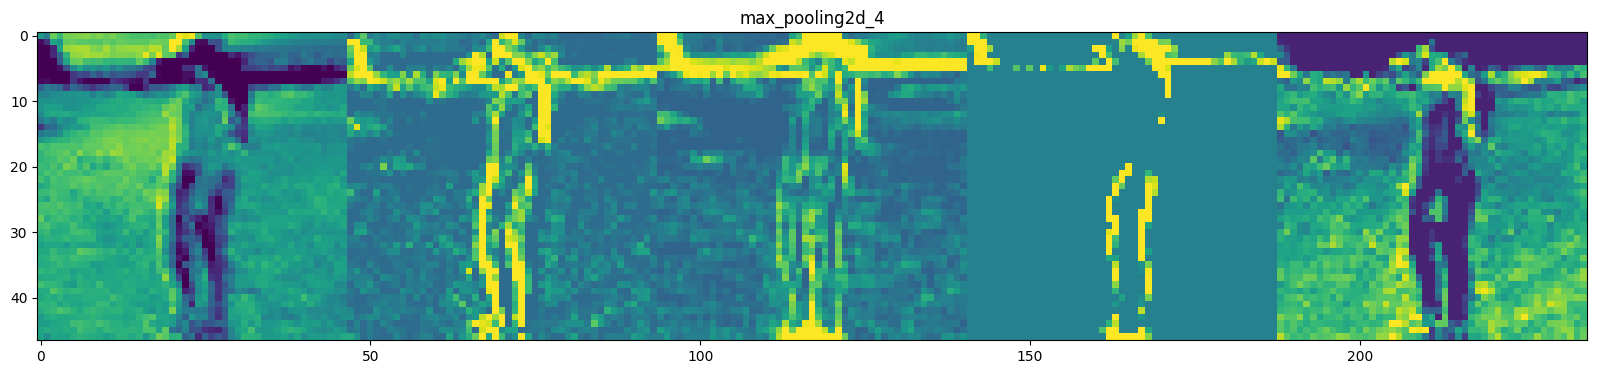

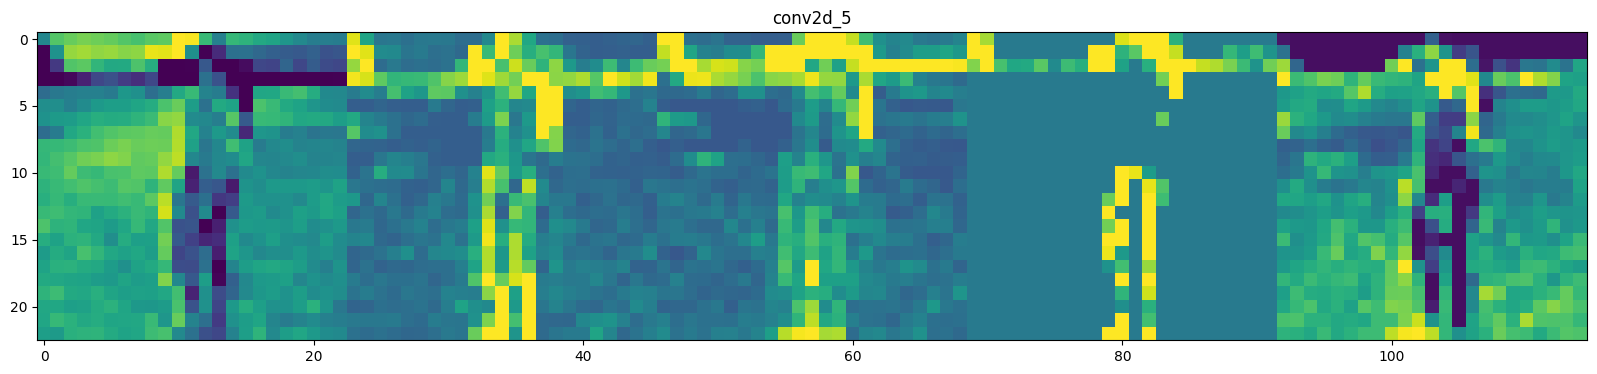

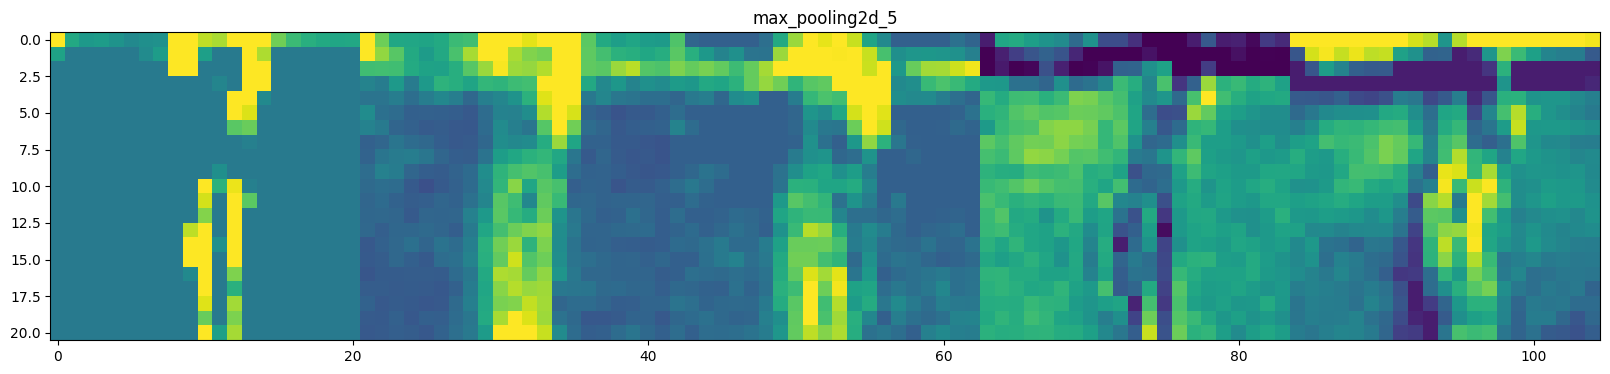

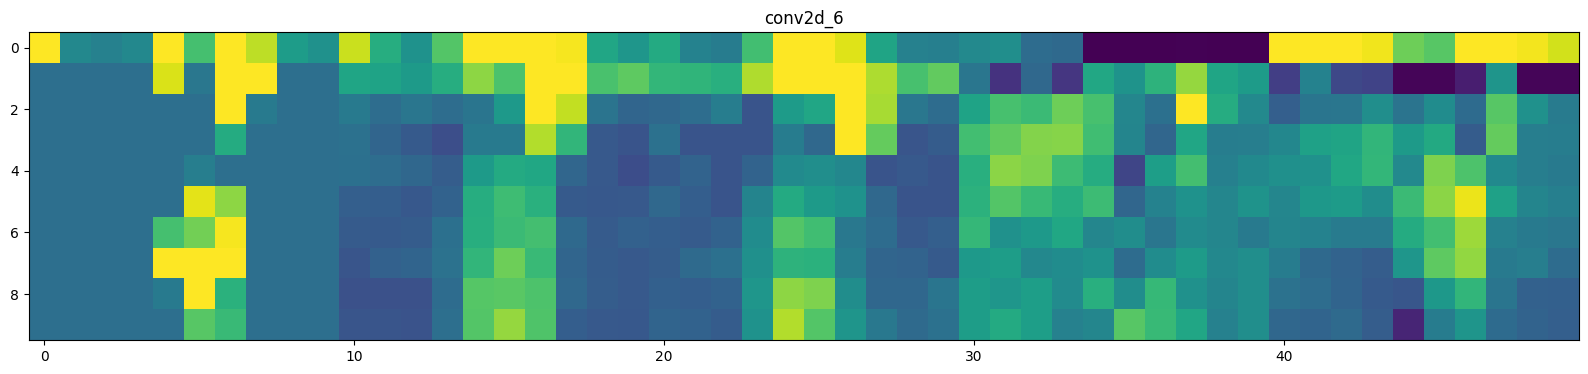

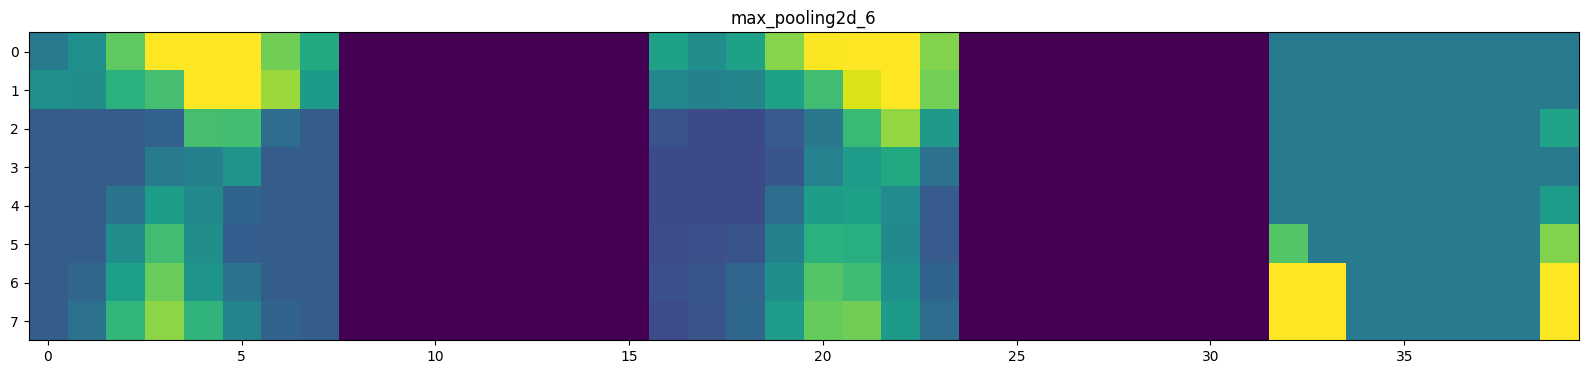

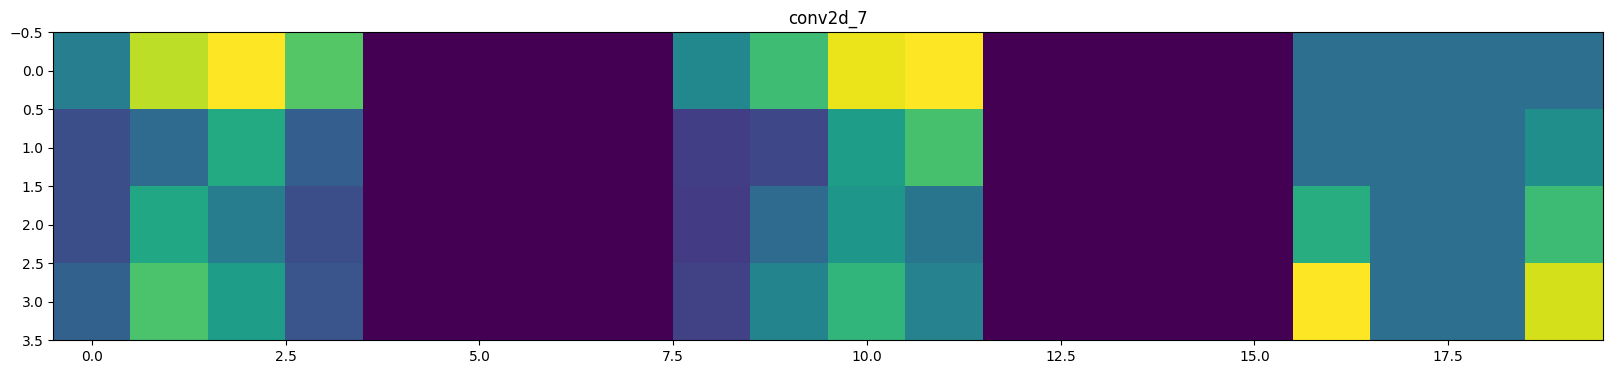

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = tf.keras.models.Model(inputs = model.inputs, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horses_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_humans_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)
# uncomment the following line if you want to pick the Xth human file manually
img_path = human_img_files[0]

img = load_img(img_path, target_size=(100, 100))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (100, 100, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 100, 100, 3)

# Rescale by 1/255
x /= 255.0

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    n_features = min(n_features,5) # limit to 5 features for easier viewing
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')